In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
import torchvision.transforms as T

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
batch_size = 60

In [15]:
transforms = T.Compose([T.ToTensor(), T.Normalize(mean=[0.5], std=[0.5])])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_shape, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, X):
        x = torch.flatten(X, 1)
        x = self.model(x)
        return x

In [7]:
class Generator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, img_shape),
            nn.Tanh()
        )

    def forward(self, X):
        x = self.model(X)
        x = x.view(-1, 1, 28, 28)
        return x

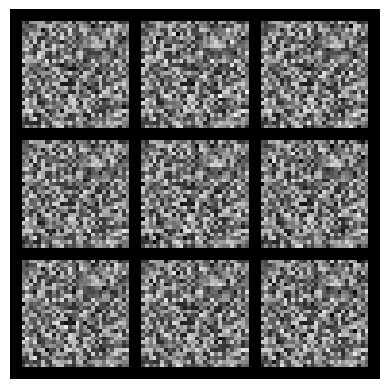

In [21]:
from torchvision.utils import make_grid

gen = Generator(1*28*28)
temp_img = torch.rand(9, 100)

def plot_generated_img(generator, fake_img):
  out = generator(fake_img)
  out = out.detach().cpu()
  img = make_grid(out, 3, 3, normalize=True)
  plt.imshow(img.permute(1, 2, 0).numpy(), cmap='gray')
  plt.axis('off')

plot_generated_img(gen, temp_img)

In [ ]:
def train(generator, discriminator, real_data, epochs, batch_size):
    d_optimizer = optim.RMSprop(generator.parameters(), lr=0.00005)
    g_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.00005)
    d_history = {'loss':[]}
    g_history = {'loss':[]}
    batches_done = 0
    for ep in range(epochs):
        for i, data in enumerate(real_data):
            noise = torch.tensor(np.random.normal(0, 1, (batch_size, 100)), dtype=torch.float, device=device, requires_grad=True)
            d_optimizer.zero_grad()
            fake_data = generator(noise).detach()
            inputs = data[0].to(device)
            d_loss = -torch.mean(discriminator(inputs)) + torch.mean(discriminator(fake_data))
            d_loss.backward()
            d_optimizer.step()

            for p in discriminator.parameters():
              p.data.clamp_(-0.01, 0.01)

            if i % 5 == 0:
              g_optimizer.zero_grad()
              gen_imgs = generator(noise)
              g_loss = -torch.mean(discriminator(gen_imgs))
              g_loss.backward()
              g_optimizer.step()

            if batches_done % 100 == 0:
              print(
                  "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                  % (ep, epochs, batches_done % len(train_dataloader), len(train_dataloader), d_loss.item(), g_loss.item())
              )
              d_history['loss'].append(d_loss.item())
              g_history['loss'].append(g_loss.item())
            batches_done += 1
    return d_history, g_history

In [ ]:
generator = Generator(1*28*28)
discriminator = Discriminator(1*28*28)
generator.to(device)
discriminator.to(device)
epochs = 20
d_history, g_history = train(generator, discriminator, train_dataloader, epochs, batch_size)

[Epoch 0/20] [Batch 0/1875] [D loss: 0.024390] [G loss: -0.011298]

[Epoch 0/20] [Batch 100/1875] [D loss: -0.156195] [G loss: -0.095748]

[Epoch 0/20] [Batch 200/1875] [D loss: -0.396236] [G loss: -0.196975]

[Epoch 0/20] [Batch 300/1875] [D loss: -0.673449] [G loss: -0.295041]

[Epoch 0/20] [Batch 400/1875] [D loss: -0.980147] [G loss: -0.386545]

[Epoch 0/20] [Batch 500/1875] [D loss: -1.336201] [G loss: -0.473529]

[Epoch 0/20] [Batch 600/1875] [D loss: -1.644563] [G loss: -0.561034]

[Epoch 0/20] [Batch 700/1875] [D loss: -1.376958] [G loss: -0.641655]

[Epoch 0/20] [Batch 800/1875] [D loss: -1.802595] [G loss: -0.728729]

[Epoch 0/20] [Batch 900/1875] [D loss: -1.965461] [G loss: -0.793657]

[Epoch 0/20] [Batch 1000/1875] [D loss: -2.092083] [G loss: -0.819563]

[Epoch 0/20] [Batch 1100/1875] [D loss: -1.931725] [G loss: -0.824094]

[Epoch 0/20] [Batch 1200/1875] [D loss: -2.307489] [G loss: -0.824735]

[Epoch 0/20] [Batch 1300/1875] [D loss: -2.037640] [G loss: -0.827390]

[Epoc

In [23]:
def plot_results(d_history, g_history):
    plt.figure(figsize=(10, 5))
    plt.plot(d_history['loss'], color='r', label='Discriminator')
    plt.plot(g_history['loss'], color='g', label='Generator')
    plt.title("Training Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()

# plot_results(d_history, g_history)

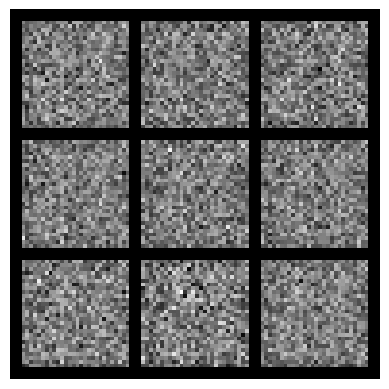

In [ ]:
noise = torch.tensor(np.random.normal(0, 1, (9, 100)), dtype=torch.float, device=device)

plot_generated_img(generator, noise)

## WGAN Gradient Penalty

In [9]:
from torch.autograd import Variable
import torch.autograd as autograd

Tensor = torch.cuda.FloatTensor

In [10]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [12]:
b1 = 0.5
b2 = 0.999
latent_dim = 100
lambda_gp = 10
n_critic = 5
lr = 2e-4

def train_gp(generator, discriminator, epochs, lr, batch_size, dataloader):
  optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
  optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
  d_history = {'loss':[]}
  g_history = {'loss':[]}
  batches_done = 0
  for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
      real_imgs = Variable(imgs.type(Tensor))
      optimizer_D.zero_grad()

      z = Variable(Tensor(np.random.normal(0, 1, (batch_size, 100))))

      fake_imgs = generator(z)

      real_validity = discriminator(real_imgs)
      fake_validity = discriminator(fake_imgs)

      gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)

      d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

      d_loss.backward()
      optimizer_D.step()

      optimizer_G.zero_grad()

      # Train the generator every n_critic steps
      if i % n_critic == 0:
        fake_imgs = generator(z)

        fake_validity = discriminator(fake_imgs)
        g_loss = -torch.mean(fake_validity)

        g_loss.backward()
        optimizer_G.step()
        
        if i%100 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        batches_done += n_critic
        d_history['loss'].append(d_loss.item())
        g_history['loss'].append(g_loss.item())
  return d_history, g_history

In [18]:
generator = Generator(1*28*28)
discriminator = Discriminator(1*28*28)
generator.cuda()
discriminator.cuda()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [19]:
epochs = 50
d_history, g_history = train_gp(generator, discriminator, epochs, lr = lr, batch_size = batch_size, dataloader=train_dataloader)

[Epoch 0/50] [Batch 0/1000] [D loss: 7.995479] [G loss: -0.038643]
[Epoch 0/50] [Batch 100/1000] [D loss: -27.980318] [G loss: -7.452043]
[Epoch 0/50] [Batch 200/1000] [D loss: -5.881115] [G loss: -18.864239]
[Epoch 0/50] [Batch 300/1000] [D loss: -1.438462] [G loss: -16.967497]
[Epoch 0/50] [Batch 400/1000] [D loss: -1.552049] [G loss: -12.581004]
[Epoch 0/50] [Batch 500/1000] [D loss: -2.242076] [G loss: -7.768089]
[Epoch 0/50] [Batch 600/1000] [D loss: -4.387874] [G loss: -4.569327]
[Epoch 0/50] [Batch 700/1000] [D loss: -5.446371] [G loss: -2.142610]
[Epoch 0/50] [Batch 800/1000] [D loss: -5.922494] [G loss: -2.944379]
[Epoch 0/50] [Batch 900/1000] [D loss: -6.133915] [G loss: -3.039549]
[Epoch 1/50] [Batch 0/1000] [D loss: -5.443505] [G loss: 1.337751]
[Epoch 1/50] [Batch 100/1000] [D loss: -6.919270] [G loss: 3.137726]
[Epoch 1/50] [Batch 200/1000] [D loss: -6.322300] [G loss: 1.753176]
[Epoch 1/50] [Batch 300/1000] [D loss: -5.825101] [G loss: 1.014278]
[Epoch 1/50] [Batch 400/1

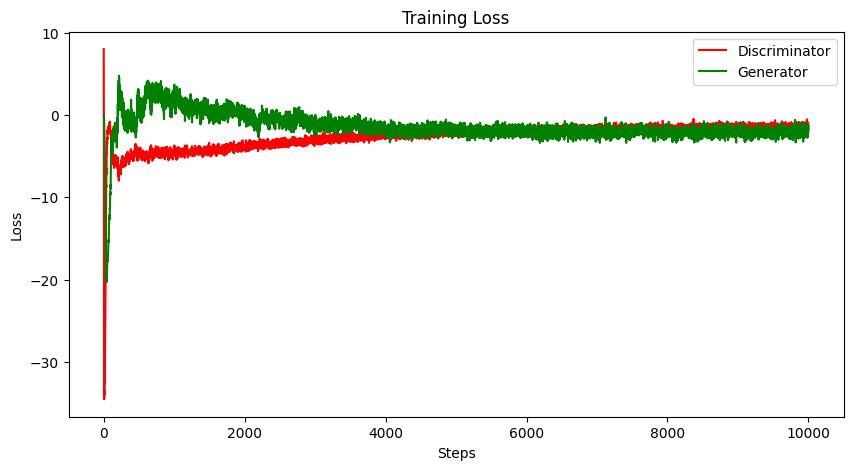

In [24]:
plot_results(d_history, g_history)

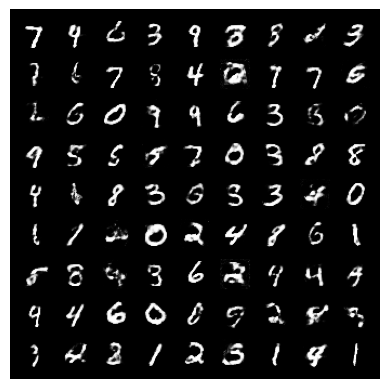

In [33]:
noise = torch.tensor(np.random.normal(0, 1, (81, 100)), dtype=torch.float, device=device)

plot_generated_img(generator, noise, n_img=81)

In [26]:
torch.save(generator.state_dict(), 'generator_gp_1.pth')
torch.save(discriminator.state_dict(), 'discriminator_gp_1_pth')

In [31]:
def plot_generated_img(generator, fake_img, n_img=9):
  out = generator(fake_img)
  out = out.detach().cpu()
  img = make_grid(out, int(n_img**0.5), int(n_img**0.5), normalize=True)
  plt.imshow(img.permute(1, 2, 0).numpy(), cmap='gray')
  plt.axis('off')